#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [190]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as ltb

In [191]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [192]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [193]:
data.sort_index(inplace=True)

In [194]:
data = data.resample('1H').sum()

In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод**

В процессе подготовки данных было проведено ресемлирование по одному часу, при этом заказы на такси были сложены.

## Анализ

<AxesSubplot:title={'center':'общее количество заказов'}, xlabel='datetime', ylabel='Заказов такси'>

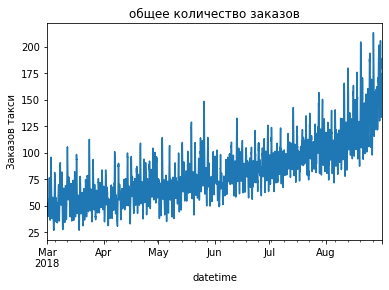

In [196]:
data['rolling_mean'] = data.rolling(10).mean()
plt.title('общее количество заказов')
plt.xlabel("Дата")
plt.ylabel("Заказов такси")
data['rolling_mean'].plot()

In [197]:
data = data.drop(['rolling_mean'], axis=1)

In [198]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Из графика ничего непонятно, необходимо проанализировать сезонность и тренды

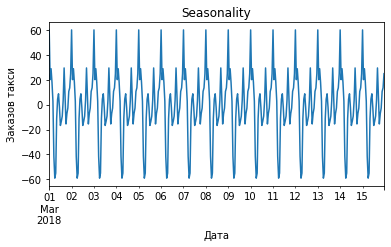

In [199]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 3))
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.xlabel("Дата")
plt.ylabel("Заказов такси")
plt.show()

**Вывод**

Из графика видно, что каждый день имеются ярко-выраженные максимумы, определим эти максимумы.

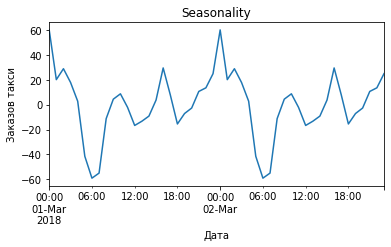

In [200]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 3))
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.xlabel("Дата")
plt.ylabel("Заказов такси")
plt.show()

**Вывод**

Из графика можно сделать вывод о том, что пик заказов приходится на 00:00 ночи.

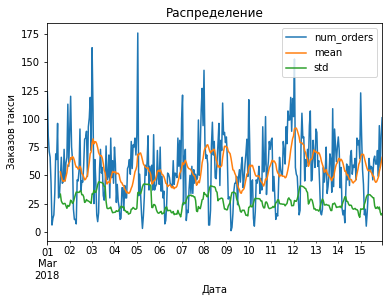

In [201]:
data_query = data['2018-03-01':'2018-03-15'].copy()
data_query['mean'] = data_query['num_orders'].rolling(15).mean()
data_query['std'] = data_query['num_orders'].rolling(15).std()
data_query.plot() 
plt.title('Распределение')
plt.xlabel("Дата")
plt.ylabel("Заказов такси")
plt.show()

**Вывод** 

Из данного графика можно сделать вывод о том, что процесс не является стационарным, среднее отклонение постоянно изменяется, необходимо нормализовать данные.

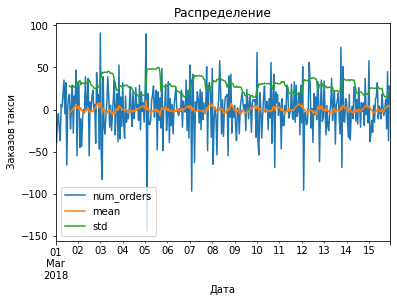

In [203]:
data_query = data['2018-03-01':'2018-03-15'].copy()
data_query = data_query - data_query.shift()

data_query['mean'] = data_query['num_orders'].rolling(15).mean()
data_query['std'] = data_query['num_orders'].rolling(15).std()
data_query.plot()
plt.title('Распределение')
plt.xlabel("Дата")
plt.ylabel("Заказов такси")
plt.show()

**Вывод** 

Средние отклонения заметно уменьшились, следовательно данные пригодны для машинного обучения.

## Обучение

In [88]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['minute'] = data.index.minute
    data['second'] = data.index.second
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [89]:
make_features(data, 1, 1)
print()

In [95]:
train, valid = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5) 

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [111]:
best_result = 0.75
best_iter = 0


for i in range(10, 101, 10):
    model = CatBoostClassifier(loss_function='Logloss', iterations=i)

    model.fit(features_train, target_train, cat_features=cat_features, verbose=10)
    
    prediction_valid = model.predict()
        if result < best_result:
            best_result = result
            best_est = est
            best_depth = depth

print(best_result)    
print(best_est)
print(best_depth)

35.640399126633405
100
11


**Вывод**

Наилучшую сходимость показа модель Light GBM, сходимость по метрике RMSE составляет 35.

## Тестирование

In [113]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [114]:
lgbr = ltb.LGBMRegressor(random_seed=12345, n_estimators=100, num_leaves=11) 

lgbr.fit(features_train, target_train)
        
prediction_test = lgbr.predict(features_test)

result = (mean_squared_error(target_test, prediction_test))**0.5
print(result)

45.94207476004711


**Вывод**

В ходе работы над проектом были выполнены следующие задачи:

1) Данные были ресемплерованы для более удобного их анализа;

2) Был произведен анализ данных и их нормализация;

3) Было проведено изучение различных моделей, далее на тестовой модели данные были проверены, наилучшая модель - Light GBM, сходимость по метрике RMSE составляет 45.